# Variational Autoencoder for Image Generation on MNIST Dataset 

In [ ]:
# Implementation of Variational Autoencoder for Image Generation on MNIST dataset
#To understand the VAE Architectures & use VAE for GenAI

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy # for KL loss
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K

In [ ]:
(x_train,_),(x_test,_) = mnist.load_data()        # labels are ignored (denoted by _).
x_train = x_train.astype('float32') / 255.0       # Normalization (/255.0): Scales pixel values to the range [0, 1]
x_test = x_test.astype('float32') / 255.0
x_train = np.reshape(x_train, (-1, 28*28))       # Flattens the 28x28 images into vectors of shape (28*28 = 784).
x_test = np.reshape(x_test, (-1, 28*28))



11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Defining Hyperparameters
input_shape = (28*28,)    # Shape of the flattened input (28*28 pixels).
latent_dim = 2            # Number of dimensions in the latent space (2D for visualization).
intermediate_dim = 256    #  Number of units in the hidden layer.

In [ ]:
inputs = Input(shape = input_shape, name='encode_input')
x = Dense(intermediate_dim, activation = 'relu')(inputs)      # First layer has 256 neurons with ReLU activation for feature extraction.
z_mean = Dense(latent_dim, name = 'z_mean')(x)
z_log_var = Dense(latent_dim, name= 'z_log_var')(x)          # 2 parallel output layers (z_mean, z_log_var) represent the mean and variance of the latent distribution.

In [ ]:
# Reparameterization Trick - Samples latent vectors from the distribution to ensure the model is differentiable.

def sampling(args):
  z_mean, z_log_var = args
  batch = tf.shape(z_mean)[0]
  dim = tf.shape(z_mean)[1]
  epsilon = tf.keras.backend.random_normal(shape=(batch, dim))       # epsilon: Random noise added to the mean
  return z_mean + tf.exp(0.5 * z_log_var)* epsilon


In [ ]:
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])     # Lambda: Custom layer for reparameterization using the sampling function.

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')                     # Model: Combines the input and latent outputs into the encoder model.

encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encode_input (InputLayer) │ (None, 784)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │        200,960 │ encode_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │            514 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │            514 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z (Lambda)                │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 201,988 (789.02 KB)

 Trainable params: 201,988 (789.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
latent_inputs = Input(shape=(latent_dim,), name = 'z_sampling')           # Takes the latent vector (𝑧) as input
x = Dense(intermediate_dim, activation = 'relu')(latent_inputs)
outputs = Dense(28*28, activation='sigmoid')(x)
                                                            # First layer expands 𝑧 into higher-dimensional features.
                                                            # Second layer reconstructs the original image, using the sigmoid activation to output pixel values in [0, 1].

decoder = Model(latent_inputs, outputs, name = 'decoder') # Combines input and output into the decoder model.

decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)              │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 784)                 │         201,488 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 202,256 (790.06 KB)

 Trainable params: 202,256 (790.06 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Building the VAE
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name= 'vae_mlp')       # Combines the encoder and decoder into a single Variational Autoencoder model.
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name= 'vae_mlp')

# Custom Loss Layer
class CustomVariationalLoss(tf.keras.layers.Layer):
  def call(self, inputs):
    y_true, y_pred, z_mean, z_log_var = inputs
    reconstruction_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)*28*28         # Measures how closely the reconstructed image matches the input.
    kl_loss = 1 + z_log_var - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_var)     # Encourages 𝑧  to follow a standard normal distribution 𝑁 ( 0 , 1 ).
    kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = tf.keras.backend.mean(reconstruction_loss + kl_loss)
    self.add_loss(vae_loss)
    return y_pred


# VAE MODEL
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, CustomVariationalLoss()([inputs, outputs, encoder(inputs)[0], encoder(inputs)[1]]), name='vae_mlp')   # pass z_mean and z_log_var to the custom layer
vae.compile(optimizer='adam')
vae.summary()


Model: "vae_mlp"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encode_input (InputLayer) │ (None, 784)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder (Functional)      │ [(None, 2), (None, 2), │        201,988 │ encode_input[0][0],    │
│                           │ (None, 2)]             │                │ encode_input[0][0],    │
│                           │                        │                │ encode_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder (Functional)      │ (None, 784)            │        202,256 │ encoder[2][2]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ custom_variational_loss   │ (None, 784)            │              0 │ encode_input[0][0],    │
│ (CustomVariationalLoss)   │                        │                │ decoder[2][0],         │
│                           │                        │                │ encoder[3][0],         │
│                           │                        │                │ encoder[4][1]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 404,244 (1.54 MB)

 Trainable params: 404,244 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
vae.fit(x_train, epochs = 5, batch_size = 128, validation_data = (x_test, None))

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 162.6140 - val_loss: 162.0567
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - loss: 161.3380 - val_loss: 161.1919
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 160.9044 - val_loss: 160.4028
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 159.7459 - val_loss: 159.4330
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 158.5723 - val_loss: 158.6461


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

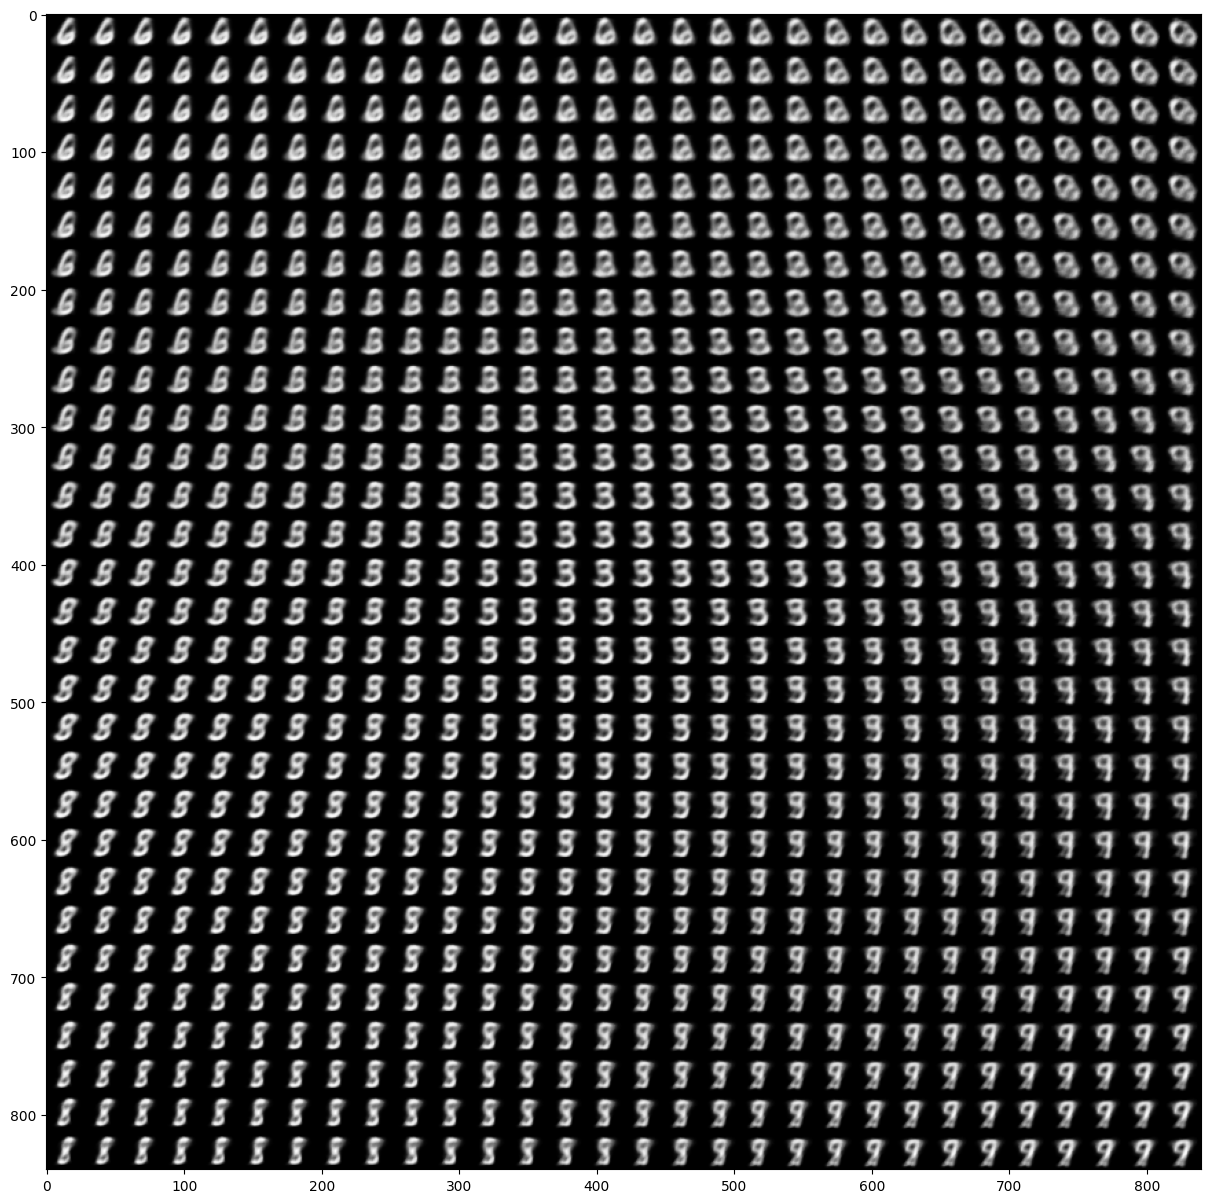

In [ ]:
import matplotlib.pyplot as plt

def plot_latent_space(vae, n = 30, figsize = 15):
  digit_size = 28
  scale = 1.0
  figure = np.zeros((digit_size * n, digit_size * n))
  grid_x = np.linspace(-scale, scale, n)
  grid_y = np.linspace(-scale, scale, n)[:: -1]
  for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
      z_sample = np.array([[xi, yi]])
      x_decoded = decoder.predict(z_sample)
      digit = x_decoded[0].reshape(digit_size, digit_size)
      figure[
        i * digit_size : (i + 1) * digit_size,
        j * digit_size : (j + 1) * digit_size,
      ] = digit
  plt.figure(figsize=(figsize, figsize))
  plt.imshow(figure, cmap = 'Greys_r')
  plt.show()
plot_latent_space(vae)

In [ ]:
# Fashion mnist dataset

In [ ]:
from tensorflow.keras.datasets import fashion_mnist

(x_train,_),(x_test,_) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.reshape(x_train, (-1, 28*28))
x_test = np.reshape(x_test, (-1, 28*28))


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
input_shape = (28*28,)
latent_dim = 2
intermediate_dim = 256

In [ ]:
inputs = Input(shape = input_shape, name='encode_input')
x = Dense(intermediate_dim, activation = 'relu')(inputs)
z_mean = Dense(latent_dim, name = 'z_mean')(x)
z_log_var = Dense(latent_dim, name= 'z_log_var')(x)

In [ ]:
def sampling(args):
  z_mean, z_log_var = args
  batch = tf.shape(z_mean)[0]
  dim = tf.shape(z_mean)[1]
  epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
  return z_mean + tf.exp(0.5 * z_log_var)* epsilon

In [ ]:
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encode_input (InputLayer) │ (None, 784)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 256)            │        200,960 │ encode_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │            514 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │            514 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z (Lambda)                │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 201,988 (789.02 KB)

 Trainable params: 201,988 (789.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
latent_inputs = Input(shape=(latent_dim,), name = 'z_sampling')
x = Dense(intermediate_dim, activation = 'relu')(latent_inputs)
outputs = Dense(28*28, activation='sigmoid')(x)

decoder = Model(latent_inputs, outputs, name = 'decoder')
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)              │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 784)                 │         201,488 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 202,256 (790.06 KB)

 Trainable params: 202,256 (790.06 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name= 'vae_mlp')
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name= 'vae_mlp')

class CustomVariationalLoss(tf.keras.layers.Layer):
  def call(self, inputs):
    y_true, y_pred, z_mean, z_log_var = inputs
    reconstruction_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)*28*28
    kl_loss = 1 + z_log_var - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_var)
    kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = tf.keras.backend.mean(reconstruction_loss + kl_loss)
    self.add_loss(vae_loss)
    return y_pred

# VAE MODEL
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, CustomVariationalLoss()([inputs, outputs, encoder(inputs)[0], encoder(inputs)[1]]), name='vae_mlp')   # pass z_mean and z_log_var to the custom layer
vae.compile(optimizer='adam')
vae.summary()


Model: "vae_mlp"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encode_input (InputLayer) │ (None, 784)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder (Functional)      │ [(None, 2), (None, 2), │        201,988 │ encode_input[0][0],    │
│                           │ (None, 2)]             │                │ encode_input[0][0],    │
│                           │                        │                │ encode_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder (Functional)      │ (None, 784)            │        202,256 │ encoder[2][2]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ custom_variational_loss_1 │ (None, 784)            │              0 │ encode_input[0][0],    │
│ (CustomVariationalLoss)   │                        │                │ decoder[2][0],         │
│                           │                        │                │ encoder[3][0],         │
│                           │                        │                │ encoder[4][1]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 404,244 (1.54 MB)

 Trainable params: 404,244 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
vae.fit(x_train, epochs = 5, batch_size = 128, validation_data = (x_test, None))

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 360.2059 - val_loss: 284.9809
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 280.9515 - val_loss: 277.0519
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 274.8044 - val_loss: 273.4159
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 271.4675 - val_loss: 271.0736
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 268.7460 - val_loss: 269.7028


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

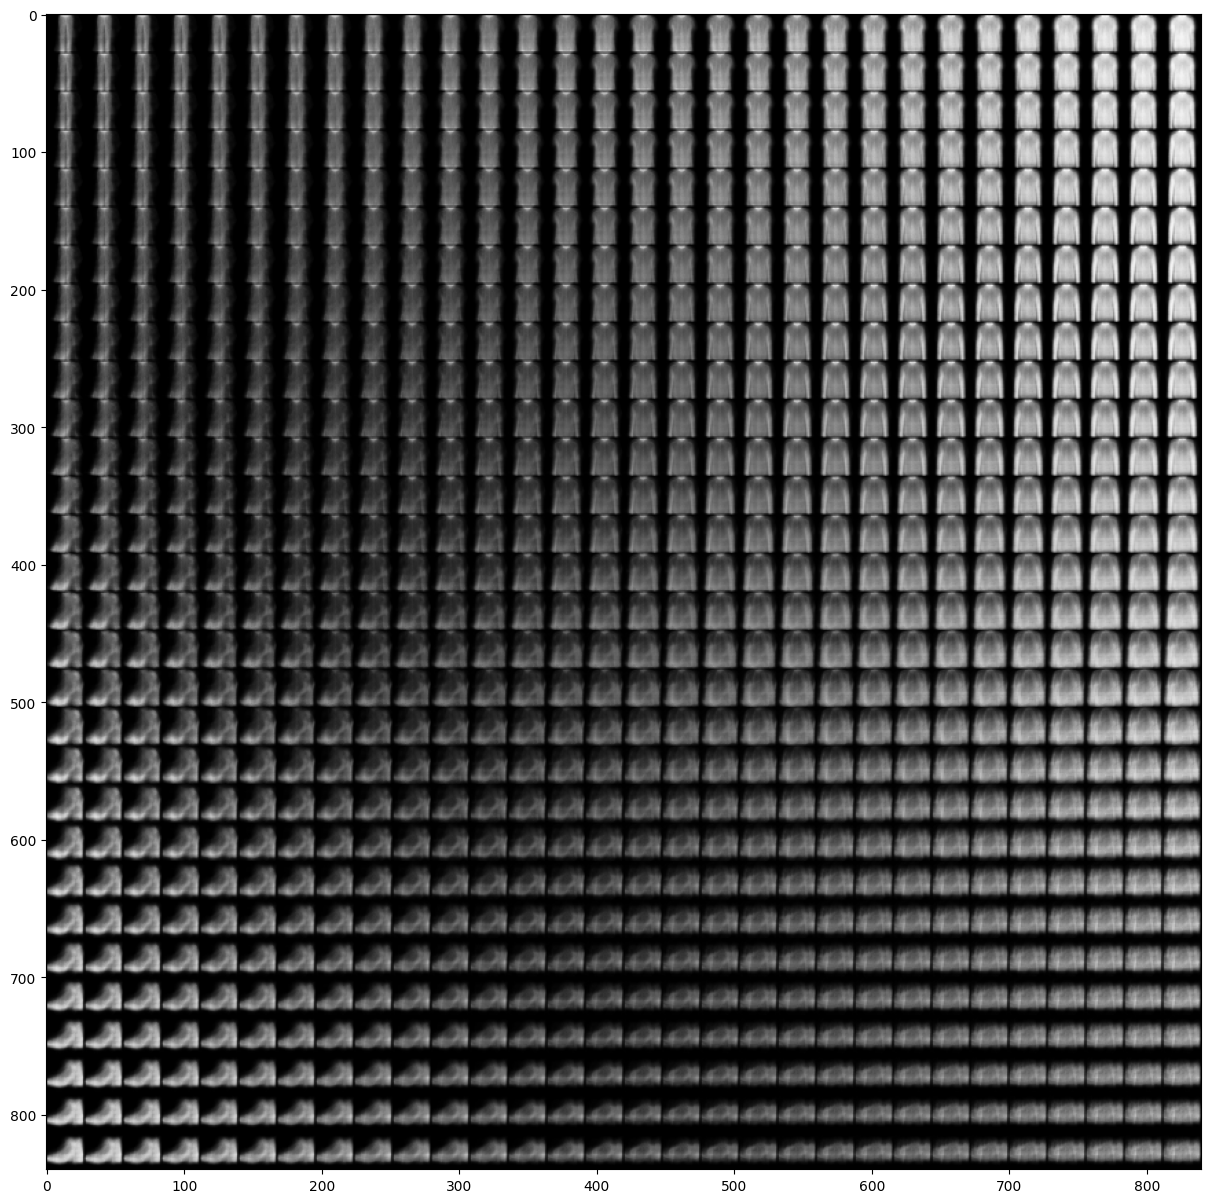

In [ ]:
import matplotlib.pyplot as plt

def plot_latent_space(vae, n = 30, figsize = 15):
  digit_size = 28
  scale = 1.0
  figure = np.zeros((digit_size * n, digit_size * n))
  grid_x = np.linspace(-scale, scale, n)
  grid_y = np.linspace(-scale, scale, n)[:: -1]
  for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
      z_sample = np.array([[xi, yi]])
      x_decoded = decoder.predict(z_sample)
      digit = x_decoded[0].reshape(digit_size, digit_size)
      figure[
        i * digit_size : (i + 1) * digit_size,
        j * digit_size : (j + 1) * digit_size,
      ] = digit
  plt.figure(figsize=(figsize, figsize))
  plt.imshow(figure, cmap = 'Greys_r')
  plt.show()
plot_latent_space(vae)


1. **Data Preprocessing:**
   - Loads the MNIST dataset (handwritten digits).
   - Normalizes the pixel values to a [0, 1] range.
   - Reshapes the data into 1D arrays (28x28 = 784 pixels).

2. **Encoder Network:**
   - The encoder is a neural network that maps the input data (images) to a latent space.
   - It has a dense layer with 256 units and a ReLU activation.
   - Outputs two vectors: the **mean** (`z_mean`) and **log variance** (`z_log_var`) of the latent distribution.
   - A **sampling function** is applied to sample the latent vector \(z\) using the mean and variance.

3. **Decoder Network:**
   - The decoder network takes the latent vector \(z\) as input and reconstructs the original image.
   - It has a dense layer and a final layer with a sigmoid activation to output pixel values between 0 and 1.

4. **VAE Model:**
   - The **VAE model** combines the encoder and decoder.
   - The **custom loss function** calculates:
     - **Reconstruction loss** (binary cross-entropy) to measure how well the decoder reconstructs the input image.
     - **KL divergence loss** to regularize the latent space and match the learned distribution to a standard normal distribution.

5. **Training:**
   - The model is compiled with the Adam optimizer and trained for 5 epochs using the MNIST training set.

6. **Latent Space Visualization:**
   - After training, the latent space is visualized by sampling points from the latent space and passing them through the decoder to generate images.

